In [1]:
!nvidia-smi

Sun Feb 16 18:51:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       On   | 00000000:01:00.0 Off |                  N/A |
| N/A   68C    P0    N/A /  N/A |    503MiB /  2002MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
# 3*3 convolutino
def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 1)
        self.layer4 = self.make_layer(block, 128, layers[1], 2)
        self.max_pool = torch.nn.MaxPool2d(8)
        self.fc = torch.nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = torch.load('/home/matvey/Morozov/Научрук/Диплом/Модель/Models/CIFAR10_ResNet.pth')
net.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [6]:
test_tf = transforms.Compose([
    transforms.ToTensor()
])

test = torchvision.datasets.CIFAR10('Модель/Datasets', download=False, train=False, transform=test_tf)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=256, shuffle=False)

### SimBA

In [7]:
import utils

/home/matvey/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [8]:
def normalize(x):
    return utils.apply_normalization(x, 'cifar')

def get_probs(model, x, y):
    output = model(normalize(x.cuda())).cpu()
    probs = torch.nn.Softmax()(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single(model, x, y, num_iters=10000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs(model, x, y)
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[torch.randint(0, 32*32, (1,))[0]] = epsilon     
        left_prob = get_probs(model, (x - diff.view(x.size()).to(device)).clamp(0, 1), y)
        if left_prob < last_prob:
            x = (x - diff.view(x.size()).to(device)).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs(model, (x + diff.view(x.size()).to(device)).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size()).to(device)).clamp(0, 1)
                last_prob = right_prob
    return x

In [9]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

In [10]:
from scipy.special import softmax

### Все классы

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


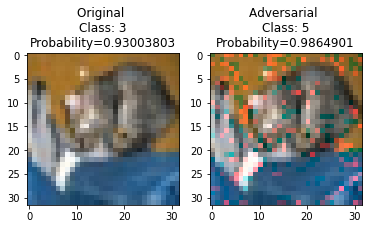

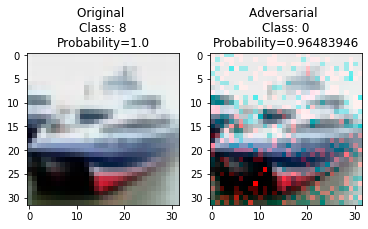

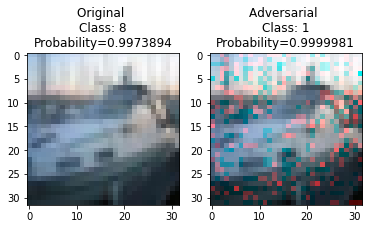

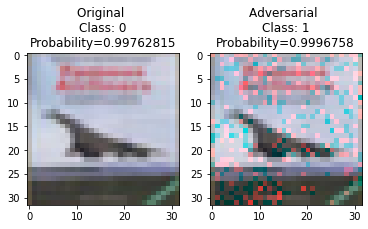

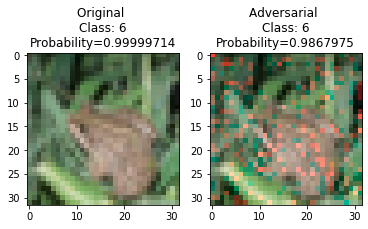

In [11]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1,3,32,32).to(device)).data.cpu().numpy()[0])

    x = simba_single(net, example_data[i].reshape(1, 3,32,32).to(device), torch.tensor(example_targets[i]).to(device), num_iters=1000, epsilon=0.3)

    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(example.data.cpu().numpy().transpose((1,2,0)))
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    axes[1].imshow(x.data.cpu().numpy()[0].transpose((1,2,0)))
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

## Fast gradient sign method

In [12]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [13]:
loss = torch.nn.CrossEntropyLoss()
example_data, example_targets = example_data.to(device), example_targets.to(device)
example_data.requires_grad = True
output = net(example_data)

loss_val = loss(output, example_targets)

net.zero_grad()
loss_val.backward()

data_grad = example_data.grad.data

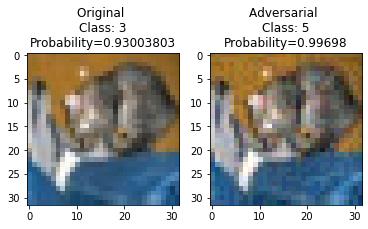

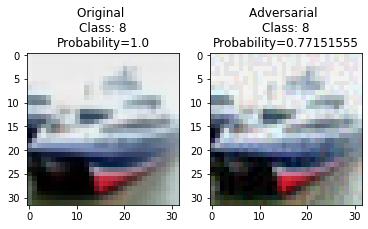

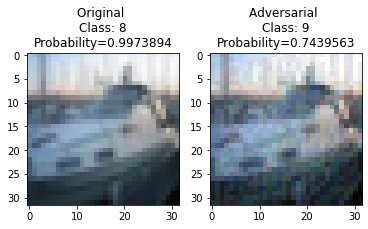

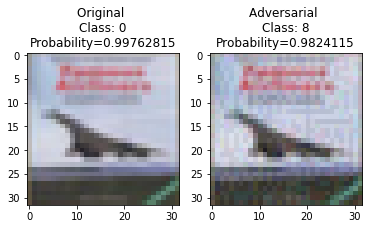

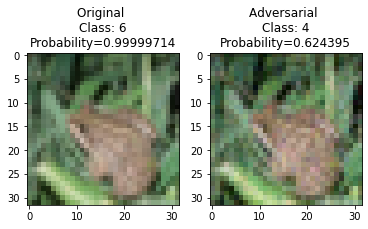

In [14]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    x = fgsm_attack(example_data[i], 0.03, data_grad[i])
    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(example.data.cpu().numpy().transpose((1,2,0)), cmap='gray')
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))

    axes[1].imshow(x.data.cpu().numpy().transpose((1,2,0)), cmap='gray')
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

## Iterative Fast gradient sign method.

In [15]:
torch.retain_graph=True
loss_val = loss(output, example_targets)

In [16]:
def ifgsm_attack(example_data, example_targets, net, loss, epsilon, iteration=1):
    example_data_copy = example_data
    
    for i in range(iteration):
        output = net(example_data)
        loss_val = loss(output, example_targets)

        net.zero_grad()
        loss_val.backward()
        data_grad = example_data.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_images = example_data + epsilon*sign_data_grad
        perturbed_images = torch.clamp(perturbed_images, 0, 1)     
        example_data = torch.tensor(perturbed_images, requires_grad=True) 
        
    example_data = example_data_copy
        
    return perturbed_images

In [17]:
retain_graph=True
perturbed_images = ifgsm_attack(example_data, example_targets, net, loss, 0.01, iteration=3)

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


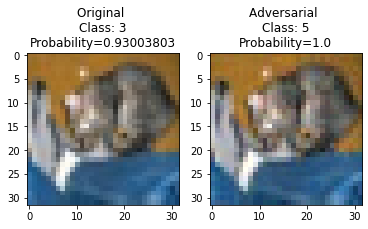

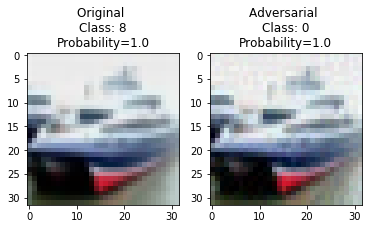

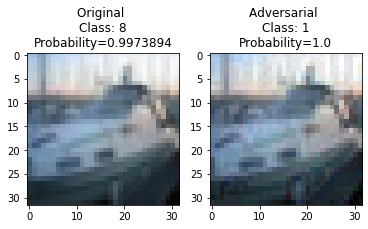

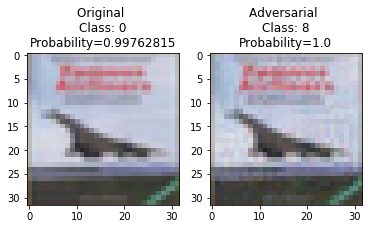

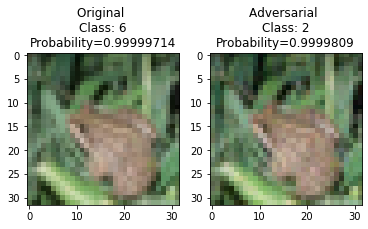

In [18]:
for i in range(5):
    if (example_targets[i]).cpu().numpy() != 1:
        example = example_data[i]
        prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])
        x = perturbed_images[i]
        prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(example.data.cpu().numpy().transpose((1,2,0)))
        axes[0].set_title('Original ' + '\n'
                          + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                          + 'Probability=' + str(np.max(prob_original)))

        axes[1].imshow(x.data.cpu().numpy().transpose((1,2,0)))
        axes[1].set_title('Adversarial ' + '\n'
                          + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                          + 'Probability=' + str(np.max(prob_adv)))

        plt.show()

### Our method

In [21]:
from numpy.linalg import norm

In [23]:
train = torchvision.datasets.CIFAR10('Модель/Datasets', download=False, train=True, transform=test_tf)
trainloader = torch.utils.data.DataLoader(dataset=train, batch_size=10000, shuffle=False)

In [24]:
examples_train = enumerate(trainloader)
batch_idx, (train_data, train_targets) = next(examples)

In [25]:
train_data = train_data.to(device)
train_targets = train_targets.to(device)

In [28]:
def nearest_image(image, label, train_data, train_targets):
    image = image.data.cpu().numpy()[0]
    all_norm = []
    for i, train_image in enumerate(train_data):
        if train_targets[i].data.cpu().numpy() != label:
            train_image = train_image.data.cpu().numpy()
            diff = train_image - image
            norm_diff = norm(diff)
            all_norm.append(norm_diff)
        else:
            all_norm.append(1e20)            

    index = np.argmin(all_norm)
    return index

def out_attack(image, label, train_data, train_targets, eps):
    index = nearest_image(image, label, train_data, train_targets)
    res = image + eps * (train_data[index] - image)
    return res.clamp(0, 255)

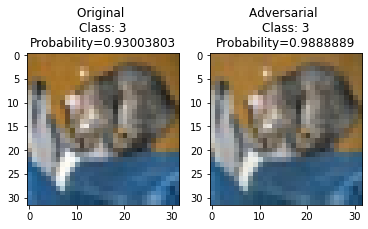

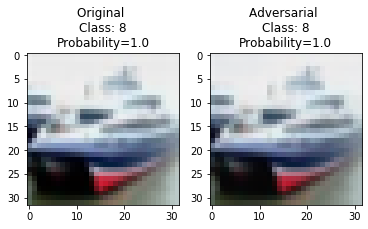

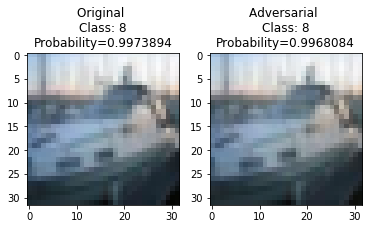

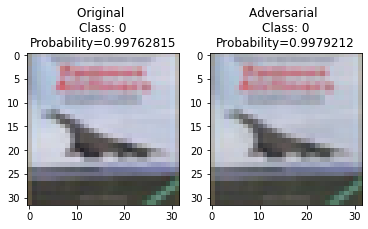

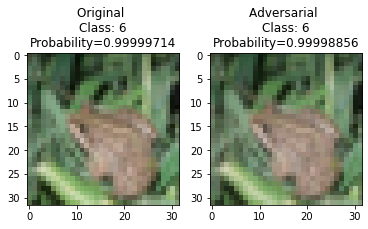

In [33]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])        
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(example.data.cpu().numpy().transpose((1,2,0)))
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    x = out_attack(example, example_targets[i].data.cpu().numpy(), train_data, train_targets, 0.1)
    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    axes[1].imshow(x.data.cpu().numpy().transpose((1,2,0)))
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

In [1]:
import foolbox

NameError: name 'net' is not defined